### Check differentiability of the code!

This notebook checks that the differentiability of the code.
Capable of finding an initial condition to generate the final data signal by backprobagating through the solver.

In [49]:
import os
os.environ["JAX_ENABLE_X64"] = "true"
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from ipywidgets import interact
from ml_collections import ConfigDict
from models.ETD_KT_CM_JAX_Vectorised import *
from filters import resamplers
from filters.filter import ParticleFilter
from jax import config
from jax import grad, jit, vmap
# import jaxopt

config.update("jax_enable_x64", True)

model params:

In [50]:
signal_params = ConfigDict(KDV_params_2)
signal_params.update(E=1,method='Dealiased_ETDRK4',nx = 128,P=0,S=0)
key = jax.random.PRNGKey(0)
signal_model = ETD_KT_CM_JAX_Vectorised(signal_params)
initial_signal = initial_condition(signal_model.x, signal_params.E, signal_params.initial_condition)
final, all = signal_model.run(initial_signal, signal_model.params.nt, None,key)
#final = jnp.sin(2*jnp.pi*signal_model.x) 


In [51]:
forward_model_params = ConfigDict(KDV_params_2)
forward_model_params.update(E=1,method='Dealiased_ETDRK4',nx = 128,P=0,S=0)
forward_model = ETD_KT_CM_JAX_Vectorised(signal_params)

# Randomly initialize the initial conditions for the forward model
key = jax.random.PRNGKey(0)
random_initial_conditions = initial_signal + 0.2*jnp.sin(8*jnp.pi*signal_model.x) + 0.2*jnp.sin(16*jnp.pi*signal_model.x)

# Define the loss function as the L2 error between the forward model's final state and the signal model's final state
def loss_fn(initial_conditions):
    forward_final, _ = forward_model.run(initial_conditions, forward_model.params.nt, None,key)
    return jnp.linalg.norm(forward_final - final)

# Compute the gradient of the loss function with respect to the initial conditions
grad_loss_fn = grad(loss_fn)

# Perform gradient descent to minimize the loss
learning_rate = 0.001
num_iterations = 10
optimized_initial_conditions = random_initial_conditions
for i in range(num_iterations):
    loss = loss_fn(optimized_initial_conditions)
    print(f"Iteration {i}, Loss: {loss}")
    gradients = grad_loss_fn(optimized_initial_conditions)
    optimized_initial_conditions -= learning_rate * gradients

# The optimized initial conditions are now stored in `optimized_initial_conditions`

Iteration 0, Loss: 6.200645533128077
Iteration 1, Loss: 6.115352422920503
Iteration 2, Loss: 6.09085057719177
Iteration 3, Loss: 6.0619356981745645
Iteration 4, Loss: 6.023478555626024
Iteration 5, Loss: 5.964294548971218
Iteration 6, Loss: 5.891634274517665
Iteration 7, Loss: 5.83895352301849
Iteration 8, Loss: 5.806160962926289
Iteration 9, Loss: 5.734798531808235


In [52]:
# Define the loss function as the L2 error between the forward model's final state and the signal model's final state
@jit
def loss_fn(initial_conditions):
    forward_final, _ = forward_model.run(initial_conditions, forward_model.params.nt, None, key)
    return jnp.linalg.norm(forward_final - final)

# Compute the gradient of the loss function with respect to the initial conditions
@jit
def compute_gradients(initial_conditions):
    return grad(loss_fn)(initial_conditions)

# Perform gradient descent to minimize the loss
@jit
def optimize(initial_conditions, learning_rate):
    gradients = compute_gradients(initial_conditions)
    updated_conditions = initial_conditions - learning_rate * gradients
    loss = loss_fn(updated_conditions)
    return updated_conditions, loss

# Initialize variables for optimization
optimized_initial_conditions = random_initial_conditions
learning_rate = 0.001
num_iterations = 10
# Optimization loop
for i in range(num_iterations):
    optimized_initial_conditions, loss = optimize(optimized_initial_conditions, learning_rate)
    print(f"Iteration {i}, Loss: {loss}")

# The optimized initial conditions are now stored in `optimized_initial_conditions`

Iteration 0, Loss: 6.115352422920561
Iteration 1, Loss: 6.090850577191891
Iteration 2, Loss: 6.061935698174643
Iteration 3, Loss: 6.023478555626143
Iteration 4, Loss: 5.964294548971637
Iteration 5, Loss: 5.891634274517972
Iteration 6, Loss: 5.838953523017508
Iteration 7, Loss: 5.806160962922484
Iteration 8, Loss: 5.734798531795041
Iteration 9, Loss: 5.4441896820131435


In [62]:
import optax
# Define the optimizer
learning_rate = 0.0001# note will only learn to about this precsion
optimizer = optax.adam(learning_rate, b1=0.9, b2=0.999, eps=1e-8)

# Initialize the optimizer state
opt_state = optimizer.init(random_initial_conditions)
num_iterations = 200
# Optimization loop using Adam
optimized_initial_conditions = random_initial_conditions

for i in range(num_iterations):
    loss, gradients = jax.value_and_grad(loss_fn)(optimized_initial_conditions)
    updates, opt_state = optimizer.update(gradients, opt_state)
    optimized_initial_conditions = optax.apply_updates(optimized_initial_conditions, updates)
    print(f"Iteration {i}, Loss: {loss}")

# The optimized initial conditions are now stored in `optimized_initial_conditions`

Iteration 0, Loss: 6.2006455331281165
Iteration 1, Loss: 6.193647619497915
Iteration 2, Loss: 6.182821271304171
Iteration 3, Loss: 6.167153821620089
Iteration 4, Loss: 6.149824181829651
Iteration 5, Loss: 6.1365710644206155
Iteration 6, Loss: 6.128981143971619
Iteration 7, Loss: 6.124556708694936
Iteration 8, Loss: 6.121515612441529
Iteration 9, Loss: 6.119194937459621
Iteration 10, Loss: 6.1173210911992575
Iteration 11, Loss: 6.115722431486526
Iteration 12, Loss: 6.114266080492364
Iteration 13, Loss: 6.112848044554742
Iteration 14, Loss: 6.111389770657785
Iteration 15, Loss: 6.10983371449599
Iteration 16, Loss: 6.108138501464395
Iteration 17, Loss: 6.106274735854062
Iteration 18, Loss: 6.104221908850703
Iteration 19, Loss: 6.101966426016269
Iteration 20, Loss: 6.099500581905634
Iteration 21, Loss: 6.096822243707324
Iteration 22, Loss: 6.093934986242171
Iteration 23, Loss: 6.090848409369343
Iteration 24, Loss: 6.087578356821182
Iteration 25, Loss: 6.084146750575375
Iteration 26, Loss: 

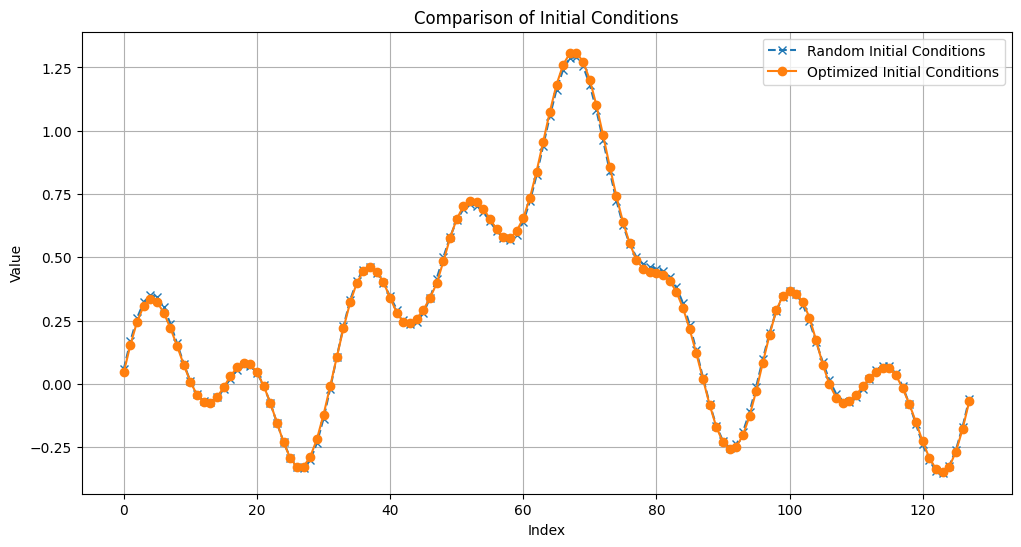

In [63]:
plt.figure(figsize=(12, 6))

# Plot random initial conditions
# plt.plot(initial_signal[0] , label='Signal Model', linestyle='-')
plt.plot(random_initial_conditions[0], label='Random Initial Conditions', linestyle='--',marker='x')

# Plot optimized initial conditions
plt.plot(optimized_initial_conditions[0], label='Optimized Initial Conditions', linestyle='-',marker='o')

plt.title('Comparison of Initial Conditions')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

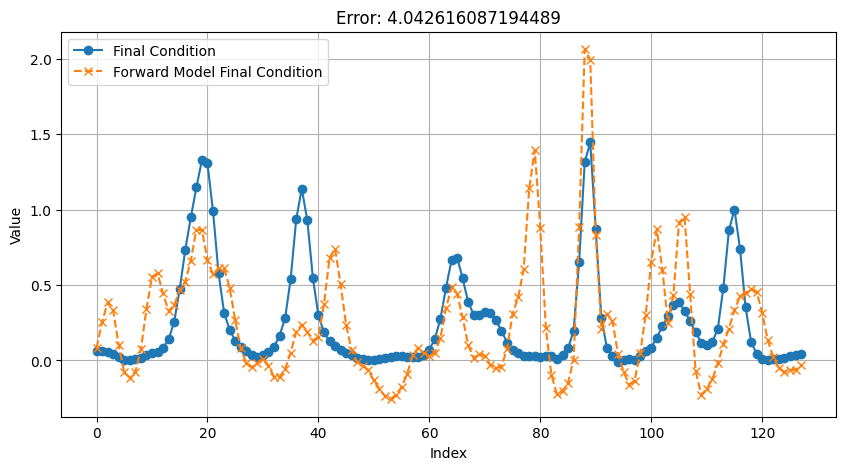

In [65]:
new_initial_conditions = optimized_initial_conditions
# Run the forward model with the optimized initial conditions
forward_final, all_rerun = signal_model.run(new_initial_conditions, forward_model.params.nt, None,key)

plt.figure(figsize=(10, 5))
plt.plot(final[0], label='Final Condition', linestyle='-', marker='o')
plt.plot(forward_final[0], label='Forward Model Final Condition', linestyle='--', marker='x')
plt.title('Final Condition')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.title('Error: ' + str(jnp.linalg.norm(forward_final - final)))
plt.show()